## The $\mathcal{T}$-similarity corrects the overconfidence of the softmax

In this notebook, we reproduce the Figure 6 of the original [paper](https://arxiv.org/pdf/2310.14814.pdf) that shows how the T-similarity corrects the overconfidence of the softmax.


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sns
import sys
import os

sys.path.append("..")
from tsim.datasets.read_dataset import RealDataSet
from tsim.models.diverse_ensemble import DiverseEnsembleMLP

custom_params = {"axes.grid": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context("talk")
pl.rcParams.update({"figure.autolayout": True})

In [ ]:
def get_base_classier(
    dataset_name,
    seed,
    nb_lab_samples_per_class,
    selection_bias,
    num_epochs,
    gamma,
):
    # Fixed params
    test_size = 0.25
    n_iters = 100
    n_classifiers = 5

    # Data split
    dataset = RealDataSet(dataset_name=dataset_name, seed=seed)

    # Percentage of labeled data
    num_classes = len(list(set(dataset.y)))
    ratio = num_classes / ((1 - test_size) * len(dataset.y))
    lab_size = nb_lab_samples_per_class * ratio

    # Split
    x_l, x_u, y_l, y_u, x_test, y_test, n_classes = dataset.get_split(
        test_size=test_size, lab_size=lab_size, selection_bias=selection_bias
    )

    # Define base classifier
    base_classifier = DiverseEnsembleMLP(
        num_epochs=num_epochs,
        gamma=gamma,
        n_iters=n_iters,
        n_classifiers=n_classifiers,
        device="cpu",
        verbose=False,
        random_state=seed,
    )

    # Train
    base_classifier.fit(x_l, y_l, x_u)

    return base_classifier, x_u, y_u


def get_barplots(
    dataset_name,
    seed,
    nb_lab_samples_per_class,
    selection_bias,
    num_epochs,
    gamma_u,
    figsize=None,
    save=False,
    path="figures",
    filename=None,
    format="svg",
    dpi=300,
    bias_name=None,
):
    base_classifier, x_u, y_u = get_base_classier(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
    )
    conf_types = ["proj_head", "similarity"]
    real_names_conf_types = {
        "proj_head": "Softmax Prediction Probability",
        "similarity": "$\mathcal{T}$-similarity",
    }
    # plot confidence
    fig, axes = pl.subplots(nrows=1, ncols=len(conf_types), figsize=figsize)
    ymax = 0
    for i, conf_type in enumerate(conf_types):
        if conf_type == "proj_head":
            pred_conf = base_classifier.predict_proba(x_u).max(axis=-1)
        else:
            pred_conf = base_classifier.predict_t_similarity(x_u)
        y_pred = base_classifier.predict(x_u)

        pred_conf_cor = pred_conf[y_u == y_pred]
        pred_conf_err = pred_conf[y_u != y_pred]

        values_cor, bins = np.histogram(pred_conf_cor, np.arange(11) / 10)
        values_err, bins = np.histogram(pred_conf_err, np.arange(11) / 10)

        bins_ = (bins - 0.05)[1:]
        axes[i].grid(alpha=0.2, axis="x")
        axes[i].bar(
            bins_,
            values_err + values_cor,
            color="#d8d5f2",
            edgecolor="black",
            width=0.1,
            linewidth=1.25,
            alpha=0.4,
            label="Correct Prediction",
        )
        axes[i].bar(
            bins_,
            values_err,
            fill=False,
            edgecolor="tab:blue",
            hatch="///",
            width=0.1,
            linewidth=0.5,
            label="Wrong Prediction",
        )
        axes[i].set_xlabel("Confidence Value")
        if i == 0 and bias_name is not None:
            axes[i].set_ylabel(f"{bias_name} \n \n Count")
        else:
            axes[i].set_ylabel("Count")
        axes[i].set_title(real_names_conf_types[conf_type])
        ax = axes[i]
        ax.grid(False)
        ax.spines["left"].set_linewidth(1)
        ax.spines["right"].set_linewidth(1)
        ax.spines["top"].set_linewidth(1)
        ax.spines["bottom"].set_linewidth(1)
        ax.tick_params(direction="out", length=6)
        _, ymax_temp = ax.get_ylim()
        ymax = max(ymax, ymax_temp)

    for ax in axes:
        ymin = 0
        tol = 1e-1 * ymax
        ax.set_ylim(0, ymax + tol)
        low = (ymax - ymin) * 0.1
        N = 3
        yticks = np.linspace(ymin + low, ymax - low, N)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks.astype(int))
        ax.locator_params(axis="x", nbins=5)

    lines_labels = [fig.axes[1].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(
        lines,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        fancybox=True,
        borderaxespad=0,
        shadow=True,
        ncol=2,
    )

    pl.tight_layout()
    if save:
        if filename is None:
            filename = f"missing_title.{format}"
        pl.savefig(
            os.path.join(path, filename), format=format, bbox_inches="tight", dpi=dpi
        )
    pl.show()

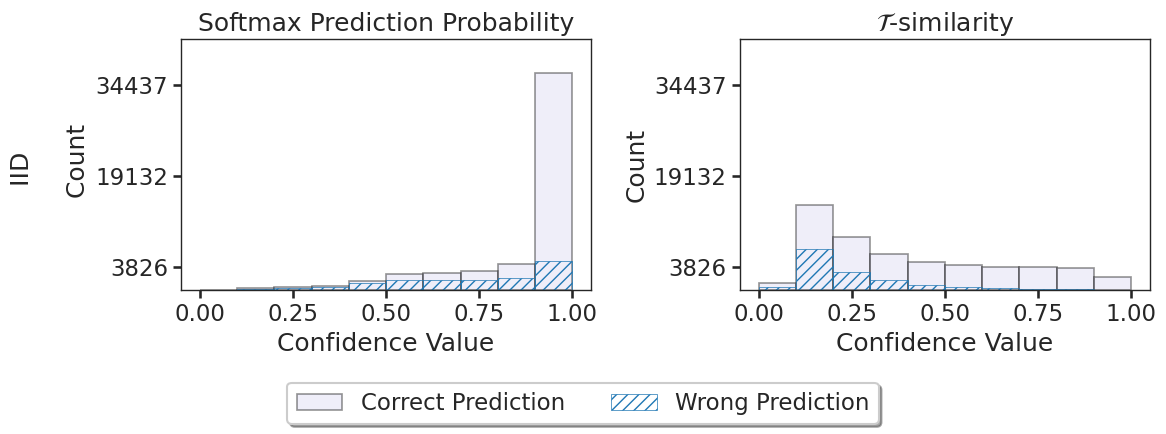

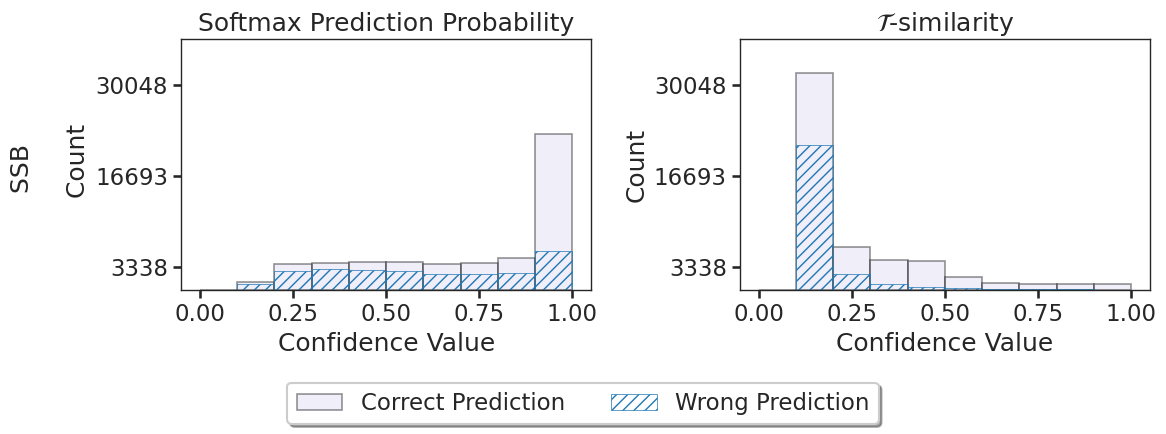

In [5]:
dataset_name = "mnist"
seed = 0
nb_lab_samples_per_class = 10
num_epochs = 5
gamma = 1
figsize = (12, 4)
save = True
path = "figures"
format = "pdf"
dpi = 100
for selection_bias in [False, True]:
    if selection_bias == False:
        bias_name = "IID"
    else:
        bias_name = "SSB"
    filename = f"calibration_{dataset_name}_{bias_name}_plot.{format}"
    get_barplots(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma,
        figsize=figsize,
        save=save,
        path=path,
        format=format,
        filename=filename,
        dpi=dpi,
        bias_name=bias_name,
    )